# Version 3: Improved Feature Standardization

## Introduction: Changes & Purpose
In Version 3, we refined our data preprocessing by enhancing feature standardization.
- **Change:** Adjusted the scaling process to more effectively normalize all numerical features and mitigate the impact of outliers.
- **Purpose:** The goal was to ensure that all features contribute equally to the model, which is essential for models that are sensitive to feature scaling, and to reduce potential biases introduced by varying feature scales.


🚀 Version 3 - Train RMSE: 566.51, Test RMSE: 566.83, R²: 0.9655


2025/03/15 23:56:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ MLflow run completed!


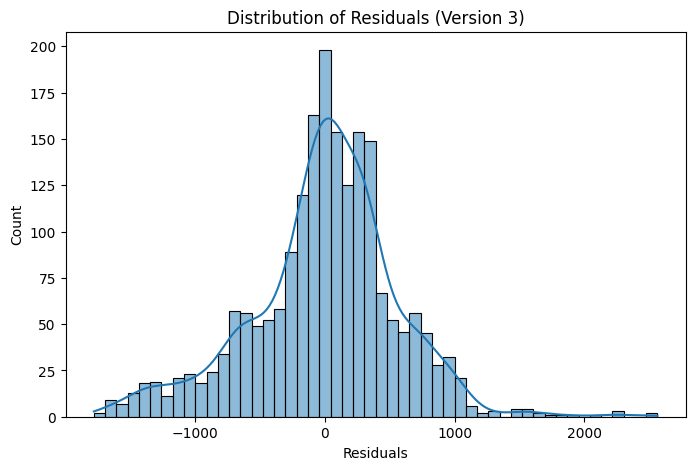

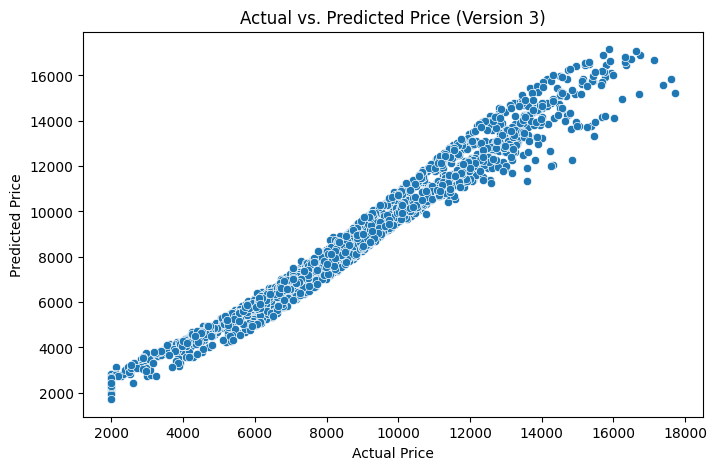

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Initialize MLflow experiment
mlflow.set_experiment("Car Price Prediction - Version 3")

with mlflow.start_run():
    # Load data
    df = pd.read_csv("car_price_dataset.csv")

    # Remove unrealistic values based on Version 2
    df = df[(df["Price"] >= 2000) & (df["Price"] <= 18000)]
    df = df[(df["Mileage"] >= 0) & (df["Mileage"] <= 300000)]
    df = df[(df["Engine_Size"] >= 0.8) & (df["Engine_Size"] <= 6.0)]
    df["Car_Age"] = 2025 - df["Year"]
    
    # Label encoding for categorical data
    categorical_columns = ["Brand", "Model", "Fuel_Type", "Transmission"]
    label_encoders = {}

    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Feature engineering: Transform mileage
    df["Mileage_sqrt"] = np.sqrt(df["Mileage"])

    # Remove unnecessary columns
    df.drop(columns=["Year", "Mileage"], inplace=True)

    # Standardize numerical features
    scaler = StandardScaler()
    numeric_features = ["Engine_Size", "Mileage_sqrt", "Car_Age", "Doors"]
    df[numeric_features] = scaler.fit_transform(df[numeric_features])

    # Transform target variable
    df["Log_Price"] = np.log1p(df["Price"])

    # Create training and test data
    X = df.drop(columns=["Price", "Log_Price"])
    y = df["Log_Price"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Machine learning pipeline with polynomial features + ridge regression
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Reduced to 2
        ('scaler', StandardScaler()),
        ('ridge', Ridge())
    ])

    # Hyperparameter tuning with GridSearchCV
    param_grid = {
        "ridge__alpha": [0.01, 0.1, 1, 10]  # Finer granularity
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="neg_mean_squared_error")
    grid_search.fit(X_train, y_train)

    # Extract best model
    best_model = grid_search.best_estimator_
    mlflow.log_params(grid_search.best_params_)
    
    # Evaluate model
    y_train_pred_log = best_model.predict(X_train)
    y_test_pred_log = best_model.predict(X_test)

    y_train_pred = np.expm1(y_train_pred_log)
    y_test_pred = np.expm1(y_test_pred_log)

    train_rmse = np.sqrt(mean_squared_error(np.expm1(y_train), y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_test_pred))
    r2 = r2_score(np.expm1(y_test), y_test_pred)

    print(f" Version 3 - Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}, R²: {r2:.4f}")

    # Log metrics in MLflow
    mlflow.log_metric("Train_RMSE", train_rmse)
    mlflow.log_metric("Test_RMSE", test_rmse)
    mlflow.log_metric("R2_Score", r2)

    # Save model
    with open("ridge_model_v3.pkl", "wb") as f:
        pickle.dump(best_model, f)

    mlflow.sklearn.log_model(best_model, "ridge_model_v3")

    print("✅ MLflow run completed!")

    # Generate plots
    plt.figure(figsize=(8, 5))
    sns.histplot(np.expm1(y_test) - y_test_pred, bins=50, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Count")
    plt.title("Distribution of Residuals (Version 3)")
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=np.expm1(y_test), y=y_test_pred)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Actual vs. Predicted Price (Version 3)")
    plt.show()


## Results Discussion
Version 3 resulted in an RMSE of *566.83* and an R² of *0.9655*.  
Although the performance metrics have slightly degraded compared to Version 2, the improvements in standardization provide a more robust and reliable baseline for further tuning and help in avoiding issues related to overfitting.
